

## Download data - Store in Drive
***


In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_url = 'https://us13.mailchimp.com/mctx/clicks?url=https%3A%2F%2Fcs.stanford.edu%2Fgroup%2Fmlgroup%2FMURA-v1.1.zip&h=6b05cc78e73f13a7fd73d527ab4085288890c4c577c0098dbc868e3ce49a4642&v=1&xid=c4ba0a150d&uid=55365305&pool=contact_facing&subject=MURA-v1.1%3A+Link+To+Dataset'

In [ ]:
## Run only ones
# import libraries
!pip install wget
import wget
import zipfile

# download data - upload to drive
wget.download(data_url,'./murav1')
with zipfile.ZipFile('murav1', 'r') as zip_ref:
  zip_ref.extractall('./mura_dl2project')

In [ ]:
!mv './mura_dl2project' './drive/MyDrive'

## Import Libraries
***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import *

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.random import set_seed

import warnings
warnings.filterwarnings("ignore")

## Labels preprocessing
***

In [ ]:
img_dir = "/content/drive/MyDrive/mura_dl2project/"

In [ ]:
# Read labels csv files
train_path = pd.read_csv("/content/drive/MyDrive/mura_dl2project/MURA-v1.1/train_image_paths.csv", header=None, names=["img_path"])
validation_path = pd.read_csv("/content/drive/MyDrive/mura_dl2project/MURA-v1.1/valid_image_paths.csv", header=None, names=["img_path"])

In [ ]:
# Train labels to dataframe
train_labels = pd.DataFrame(train_path['img_path'].str.split('/').tolist()).loc[:,2:5]
train_labels.rename(columns={2:"bodypart", 3:"patient", 4:"result", 5:"image"}, inplace=True)
train_labels = pd.concat([train_path, train_labels], axis=1)

# Validation labels to dataframe
validation_labels = pd.DataFrame(validation_path['img_path'].str.split('/').tolist()).loc[:,2:5]
validation_labels.rename(columns={2:"bodypart", 3:"patient", 4:"result", 5:"image"}, inplace=True)
validation_labels = pd.concat([validation_path, validation_labels], axis=1)


In [ ]:
# Train labels to numpy array
train_result = pd.DataFrame(train_labels['result'].str.split('_').tolist())[1]
train_labels["class"] = train_result
ytrain = np.where(train_result=="positive", 1, 0)
train_labels["result_numeric"] = ytrain
print(len(ytrain), len(ytrain)==train_labels.shape[0])

# Validation labels to numpy array
validation_result = pd.DataFrame(validation_labels['result'].str.split('_').tolist())[1]
validation_labels["class"] = validation_result
yval = np.where(validation_result=="positive", 1, 0)
validation_labels["result_numeric"] = yval
print(len(yval), len(yval)==validation_labels.shape[0])

36808 True
3197 True


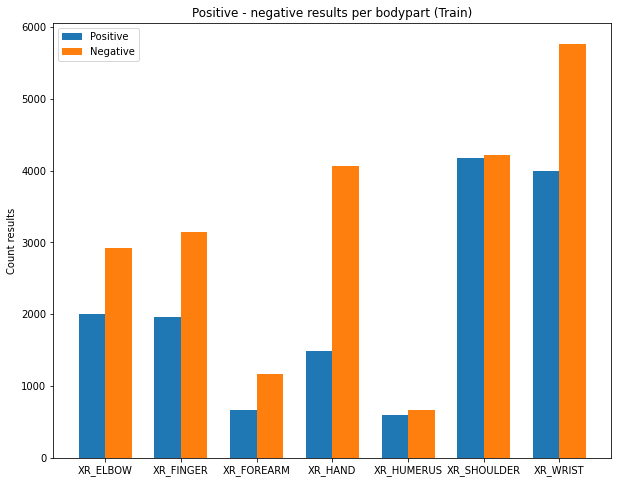

In [ ]:
# Train grouped by bodypart
train_group_bdpart = pd.DataFrame(train_labels.groupby("bodypart")["patient"].count().reset_index()).merge(pd.DataFrame(train_labels.groupby("bodypart")["result_numeric"].sum().reset_index()))
train_group_bdpart["negative"] = train_group_bdpart["patient"]-train_group_bdpart["result_numeric"]
train_group_bdpart = train_group_bdpart.rename({"result_numeric":"positive"}, axis=1)

# Train grouped by bodypart plot
labels = train_group_bdpart.bodypart
width = 0.35
x = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, train_group_bdpart.positive, width, label='Positive')
rects2 = ax.bar(x + width/2, train_group_bdpart.negative, width, label='Negative')

ax.set_ylabel('Count results')
ax.set_title('Positive - negative results per bodypart (Train)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [ ]:
# train class balance in percentages
train_group_bdpart["positive_class_rate"] = round((train_group_bdpart["positive"]/train_group_bdpart["patient"])*100,2)
train_group_bdpart["negative_class_rate"] = round((train_group_bdpart["negative"]/train_group_bdpart["patient"])*100,2)
train_group_bdpart.iloc[:,[0,4,5]]

,bodypart,positive_class_rate,negative_class_rate
0,XR_ELBOW,40.68,59.32
1,XR_FINGER,38.54,61.46
2,XR_FOREARM,36.22,63.78
3,XR_HAND,26.77,73.23
4,XR_HUMERUS,47.09,52.91
5,XR_SHOULDER,49.74,50.26
6,XR_WRIST,40.88,59.12


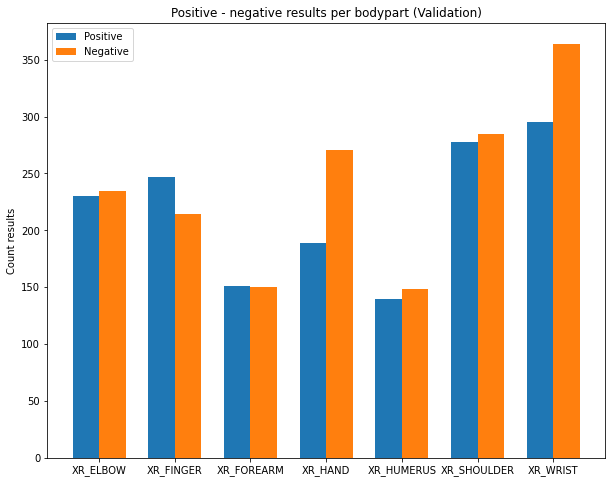

In [ ]:
# Validation grouped by bodypart
validation_group_bdpart = pd.DataFrame(validation_labels.groupby("bodypart")["patient"].count().reset_index()).merge(pd.DataFrame(validation_labels.groupby("bodypart")["result_numeric"].sum().reset_index()))
validation_group_bdpart["negative"] = validation_group_bdpart["patient"]-validation_group_bdpart["result_numeric"]
validation_group_bdpart = validation_group_bdpart.rename({"result_numeric":"positive"}, axis=1)

# Validation grouped by bodypart plot
labels = validation_group_bdpart.bodypart
width = 0.35
x = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - width/2, validation_group_bdpart.positive, width, label='Positive')
rects2 = ax.bar(x + width/2, validation_group_bdpart.negative, width, label='Negative')

ax.set_ylabel('Count results')
ax.set_title('Positive - negative results per bodypart (Validation)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

In [ ]:
# validation class balance in percentages
validation_group_bdpart["positive_class_rate"] = round((validation_group_bdpart["positive"]/validation_group_bdpart["patient"])*100,2)
validation_group_bdpart["negative_class_rate"] = round((validation_group_bdpart["negative"]/validation_group_bdpart["patient"])*100,2)
validation_group_bdpart.iloc[:,[0,4,5]]

,bodypart,positive_class_rate,negative_class_rate
0,XR_ELBOW,49.46,50.54
1,XR_FINGER,53.58,46.42
2,XR_FOREARM,50.17,49.83
3,XR_HAND,41.09,58.91
4,XR_HUMERUS,48.61,51.39
5,XR_SHOULDER,49.38,50.62
6,XR_WRIST,44.76,55.24


## Images Preprocessing
***

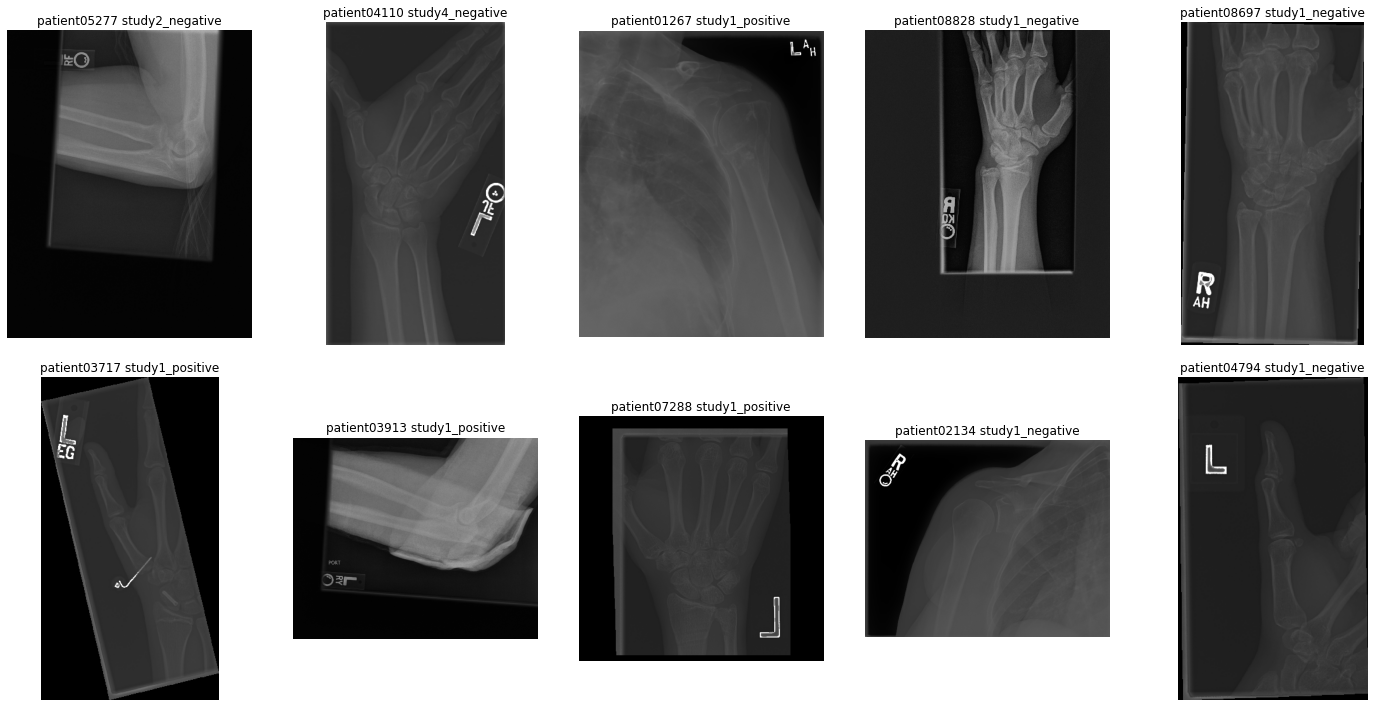

In [ ]:
# Print some images
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20, 10)
fig.tight_layout()
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.axis('off')
  indx = np.random.randint(0, train_labels.shape[0])
  img = cv2.imread(img_dir + train_labels.img_path[indx])
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.title(train_labels.patient[indx] + " " + train_labels.result[indx])

In [ ]:
## Run only ones
# Resize images and overwrite
# Train set
for i in range(train_labels.shape[0]):
  img = cv2.imread(img_dir + train_labels.img_path[i])
  img_resized = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
  cv2.imwrite(img_dir + train_labels.img_path[i], img_resized)
  if i%1000==0:
    print(f"{i} images have been processed")

# Validation set
for i in range(validation_labels.shape[0]):
  img = cv2.imread(img_dir + validation_labels.img_path[i])
  img_resized = cv2.resize(img, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
  cv2.imwrite(img_dir + validation_labels.img_path[i], img_resized)
  if i%1000==0:
    print(f"{i} images have been processed")

0 images have been processed
1000 images have been processed
2000 images have been processed
3000 images have been processed


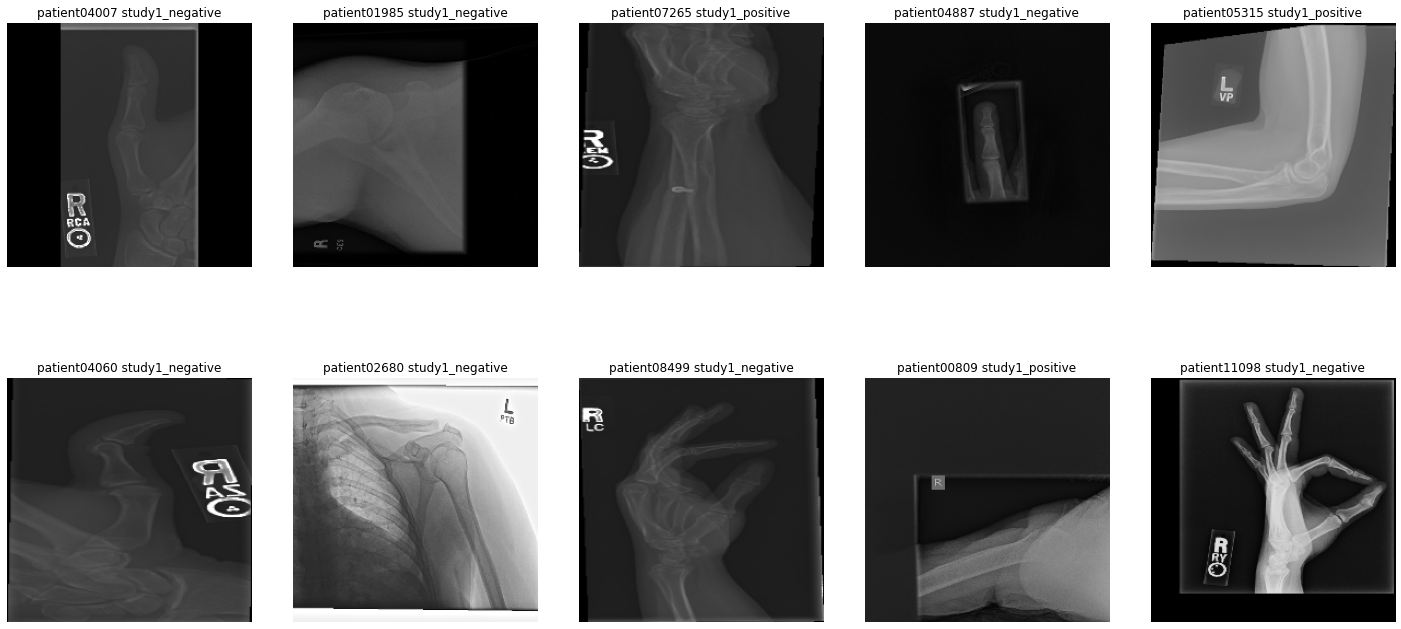

In [ ]:
# Print some images after resizing
fig, axes = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(20, 10)
fig.tight_layout()
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.axis('off')
  indx = np.random.randint(0, train_labels.shape[0])
  img = cv2.imread(img_dir + train_labels.img_path[indx])
  plt.imshow(img, cmap=plt.get_cmap('gray'))
  plt.title(train_labels.patient[indx] + " " + train_labels.result[indx])

## Create Image Generator
***


In [ ]:
def train_validation_splits(df_train, df_test, bodypart, x_col, y_col, test_size = 0.2):
  """
    Given a dataframe and the target bodypart, returns train and validation splits
  """

  train_df = df_train[df_train["bodypart"]==bodypart].loc[:,[x_col, y_col]]
  test_df = df_test[df_test["bodypart"]==bodypart].loc[:,[x_col, y_col]]

  x = train_df
  y = train_df[y_col]

  xtrain, xval, ytrain, yval = train_test_split(x, y, stratify = y, test_size = test_size, random_state = 1996)

  print("Train Balance: ", compute_class_weight("balanced", classes=[0,1], y=ytrain))
  print("Validation Balance: ", compute_class_weight("balanced", classes=[0,1], y=yval))

  return xtrain, xval, ytrain, yval, test_df



def train_validation_generators(parameters_dict_train, xtrain, img_dir, x_col, y_col, parameters_dict_val, xval, xtest):
  """
    Given train and validation datasets returns coresponding image generators
  """

  datagen = ImageDataGenerator(**parameters_dict_train)
  train_generator = datagen.flow_from_dataframe( dataframe = xtrain,
                                                 directory = img_dir,
                                                 x_col = x_col,
                                                 y_col = y_col,
                                                 batch_size = 32,
                                                 seed = 1996,
                                                 shuffle = True,
                                                 class_mode = "raw",
                                                 validate_filenames = False,
                                                 target_size = (224,224) )
  
  datagen_val = ImageDataGenerator(**parameters_dict_val)
  validation_generator = datagen_val.flow_from_dataframe( dataframe = xval,
                                                          directory = img_dir,
                                                          x_col = x_col,
                                                          y_col = y_col,
                                                          batch_size = 32,
                                                          seed = 1996,
                                                          shuffle = False,
                                                          class_mode = "raw",
                                                          validate_filenames = False,
                                                          target_size = (224,224) )
  
  datagen_test = ImageDataGenerator(rescale = 1./255.)
  test_generator = datagen_val.flow_from_dataframe( dataframe = xtest,
                                                    directory = img_dir,
                                                    x_col = x_col,
                                                    y_col = y_col,
                                                    batch_size = 64,
                                                    seed = 1996,
                                                    shuffle = False,
                                                    class_mode = "raw",
                                                    validate_filenames = False,
                                                    target_size = (224,224) )
  
  return train_generator, validation_generator, test_generator

## Model
***


### CNN

In [ ]:
# Set seeds for reproducible results
np.random.seed(6666) 
set_seed(1111)

# Create model
input = Input(shape=(224,224,3), name='Input')
x = Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation="relu", name='Conv1')(input)
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D1')(x)
x = Dropout(rate=0.2, name='Dropout1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation="relu", name='Conv2')(x)
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D2')(x)
x = Dropout(rate=0.2, name='Dropout2')(x)
x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', dilation_rate=(1, 1), activation="relu", name='Conv3')(x)
x = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='MaxPool2D3')(x)
x = Dropout(rate=0.2, name='Dropout3')(x)
x = Flatten(name='Flatten')(x)
x = Dense(units=256, kernel_initializer='glorot_uniform', activation="relu", name='Hidden1')(x)
x = Dropout(0.4, name='Dropout4')(x)
output = Dense(units=1, activation="sigmoid", name='Output')(x)

cnn_model = Model(inputs=input, outputs=output, name="sofua_cnn")
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

cnn_model.summary()

Model: "sofua_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 224, 224, 16)      448       
_________________________________________________________________
MaxPool2D1 (MaxPooling2D)    (None, 112, 112, 16)      0         
_________________________________________________________________
Dropout1 (Dropout)           (None, 112, 112, 16)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 112, 112, 32)      4640      
_________________________________________________________________
MaxPool2D2 (MaxPooling2D)    (None, 56, 56, 32)        0         
_________________________________________________________________
Dropout2 (Dropout)           (None, 56, 56, 32)        0 

### Pretrained Network

In [ ]:
input_model = Input(shape=(224,224,3))
pretrained_model = DenseNet121(include_top=False, input_shape=(224,224,3), pooling="max")

for layer in pretrained_model.layers:
  layer.trainable = False

x = pretrained_model(input_model)
x = Dense(units=256, activation="relu")(x)
output_model = Dense(units=1, activation="sigmoid")(x)

mymodel = Model(inputs=input_model, outputs=output_model, name="sofua")
mymodel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

mymodel.summary()

29089792/29084464 [==============================] - 2s 0us/step
Model: "sofua"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 7,300,161
Trainable params: 262,657
Non-trainable params: 7,037,504
_________________________________________________________________


### Evaluation function

In [ ]:
def evaluate_predictions(y_true, predictions):
  """
    Calculates different metrics, given an array of true values and a an array of predicted class probabilities
  """

  y_pred = np.array([1 if n >= 0.5 else 0 for n in predictions])
  y_true = np.array(y_true)

  print(f"Test accuracy: {round(accuracy_score(y_true, y_pred)*100,2)} %")
  print(f"Test F1 score: {round(f1_score(y_true, y_pred)*100,2)} %")
  print(f"Test Precision score: {round(precision_score(y_true, y_pred)*100,2)} %")
  print(f"Test Recall score: {round(recall_score(y_true, y_pred)*100,2)} %")
  print(f"Test Cohen Kappa score: {round(cohen_kappa_score(y_true, y_pred),2)}")

  return


 ## **Bodypart**: Forearm

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_FOREARM", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.78410311 1.37996219]
Validation Balance:  [0.7832618  1.38257576]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 1460 non-validated image filenames.
Found 365 non-validated image filenames.
Found 301 non-validated image filenames.


(46, 12, 5)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_forearm.h5')

Epoch 1/30
46/46 [==============================] - 22s 445ms/step - loss: 0.8623 - accuracy: 0.6066 - val_loss: 0.6525 - val_accuracy: 0.6384
Epoch 2/30
46/46 [==============================] - 21s 425ms/step - loss: 0.6544 - accuracy: 0.6302 - val_loss: 0.6604 - val_accuracy: 0.6384
Epoch 3/30
46/46 [==============================] - 20s 426ms/step - loss: 0.6423 - accuracy: 0.6304 - val_loss: 0.6506 - val_accuracy: 0.6329
Epoch 4/30
46/46 [==============================] - 20s 420ms/step - loss: 0.6439 - accuracy: 0.6361 - val_loss: 0.6619 - val_accuracy: 0.6274
Epoch 5/30
46/46 [==============================] - 20s 422ms/step - loss: 0.6391 - accuracy: 0.6505 - val_loss: 0.6586 - val_accuracy: 0.6329
Epoch 6/30
46/46 [==============================] - 20s 419ms/step - loss: 0.6366 - accuracy: 0.6518 - val_loss: 0.6564 - val_accuracy: 0.6329
Epoch 7/30
46/46 [==============================] - 20s 408ms/step - loss: 0.6359 - accuracy: 0.6361 - val_loss: 0.6552 - val_accuracy: 0.6575

In [ ]:
# load best model
cnn_model = load_model('./drive/MyDrive/sofua_cnn_forearm.h5')

# get predictions on test set
test_generator.reset()
pred = cnn_model.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

5/5 [==============================] - 72s 18s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 60.13 %
Test F1 score: 46.43 %
Test Precision score: 71.23 %
Test Recall score: 34.44 %
Test Cohen Kappa score: 0.2


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 57.14 %
Test F1 score: 43.56 %
Test Precision score: 59.46 %
Test Recall score: 34.38 %
Test Cohen Kappa score: 0.13


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_FOREARM", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.78410311 1.37996219]
Validation Balance:  [0.7832618  1.38257576]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 1460 non-validated image filenames.
Found 365 non-validated image filenames.
Found 301 non-validated image filenames.


(46, 12, 5)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua.h5')

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

5/5 [==============================] - 145s 28s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 77.08 %
Test F1 score: 73.56 %
Test Precision score: 87.27 %
Test Recall score: 63.58 %
Test Cohen Kappa score: 0.54


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 83.46 %
Test F1 score: 81.36 %
Test Precision score: 88.89 %
Test Recall score: 75.0 %
Test Cohen Kappa score: 0.67



 ## **Bodypart**: Elbow

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_ELBOW", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.84273504 1.22942643]
Validation Balance:  [0.84358974 1.22761194]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 3944 non-validated image filenames.
Found 987 non-validated image filenames.
Found 465 non-validated image filenames.


(124, 31, 8)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_elbow.h5')

Epoch 1/30
124/124 [==============================] - 951s 7s/step - loss: 0.7298 - accuracy: 0.5690 - val_loss: 0.6583 - val_accuracy: 0.5927
Epoch 2/30
124/124 [==============================] - 47s 378ms/step - loss: 0.6601 - accuracy: 0.5936 - val_loss: 0.6547 - val_accuracy: 0.5917
Epoch 3/30
124/124 [==============================] - 47s 375ms/step - loss: 0.6658 - accuracy: 0.5622 - val_loss: 0.6557 - val_accuracy: 0.5968
Epoch 4/30
124/124 [==============================] - 48s 382ms/step - loss: 0.6553 - accuracy: 0.5827 - val_loss: 0.6524 - val_accuracy: 0.6039
Epoch 5/30
124/124 [==============================] - 48s 379ms/step - loss: 0.6632 - accuracy: 0.5852 - val_loss: 0.6514 - val_accuracy: 0.6332
Epoch 6/30
124/124 [==============================] - 48s 379ms/step - loss: 0.6519 - accuracy: 0.6013 - val_loss: 0.6467 - val_accuracy: 0.6292
Epoch 7/30
124/124 [==============================] - 47s 375ms/step - loss: 0.6505 - accuracy: 0.6127 - val_loss: 0.6522 - val_accu

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_cnn_elbow.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

8/8 [==============================] - 2s 180ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 58.49 %
Test F1 score: 47.7 %
Test Precision score: 63.31 %
Test Recall score: 38.26 %
Test Cohen Kappa score: 0.17


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 60.76 %
Test F1 score: 47.46 %
Test Precision score: 53.85 %
Test Recall score: 42.42 %
Test Cohen Kappa score: 0.17


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_ELBOW", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.84273504 1.22942643]
Validation Balance:  [0.84358974 1.22761194]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 3944 non-validated image filenames.
Found 987 non-validated image filenames.
Found 465 non-validated image filenames.


(124, 31, 8)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua_elbow.h5')

Epoch 1/30
124/124 [==============================] - 2197s 17s/step - loss: 0.5953 - accuracy: 0.7117 - val_loss: 0.5211 - val_accuracy: 0.7437
Epoch 2/30
124/124 [==============================] - 51s 406ms/step - loss: 0.5307 - accuracy: 0.7378 - val_loss: 0.5234 - val_accuracy: 0.7599
Epoch 3/30
124/124 [==============================] - 51s 405ms/step - loss: 0.5070 - accuracy: 0.7619 - val_loss: 0.4921 - val_accuracy: 0.7771
Epoch 4/30
124/124 [==============================] - 51s 406ms/step - loss: 0.5018 - accuracy: 0.7612 - val_loss: 0.4959 - val_accuracy: 0.7649
Epoch 5/30
124/124 [==============================] - 52s 412ms/step - loss: 0.4875 - accuracy: 0.7726 - val_loss: 0.5203 - val_accuracy: 0.7254
Epoch 6/30
124/124 [==============================] - 51s 409ms/step - loss: 0.4821 - accuracy: 0.7761 - val_loss: 0.5000 - val_accuracy: 0.7599
Epoch 7/30
124/124 [==============================] - 51s 410ms/step - loss: 0.4738 - accuracy: 0.7850 - val_loss: 0.5122 - val_ac

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_elbow.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

8/8 [==============================] - 5s 422ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 78.71 %
Test F1 score: 76.71 %
Test Precision score: 83.59 %
Test Recall score: 70.87 %
Test Cohen Kappa score: 0.57


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 79.11 %
Test F1 score: 75.19 %
Test Precision score: 74.63 %
Test Recall score: 75.76 %
Test Cohen Kappa score: 0.57



 ## **Bodypart**: Finger

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_FINGER", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.81354582 1.29733164]
Validation Balance:  [0.81369427 1.29695431]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 4084 non-validated image filenames.
Found 1022 non-validated image filenames.
Found 461 non-validated image filenames.


(128, 32, 8)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_finger.h5')

Epoch 1/30
128/128 [==============================] - 992s 8s/step - loss: 0.6205 - accuracy: 0.6476 - val_loss: 0.6052 - val_accuracy: 0.6419
Epoch 2/30
128/128 [==============================] - 49s 380ms/step - loss: 0.6002 - accuracy: 0.6589 - val_loss: 0.5835 - val_accuracy: 0.6419
Epoch 3/30
128/128 [==============================] - 50s 382ms/step - loss: 0.5980 - accuracy: 0.6582 - val_loss: 0.5889 - val_accuracy: 0.6751
Epoch 4/30
128/128 [==============================] - 49s 379ms/step - loss: 0.5856 - accuracy: 0.6753 - val_loss: 0.5767 - val_accuracy: 0.6742
Epoch 5/30
128/128 [==============================] - 49s 378ms/step - loss: 0.5769 - accuracy: 0.6741 - val_loss: 0.5984 - val_accuracy: 0.6732
Epoch 6/30
128/128 [==============================] - 49s 380ms/step - loss: 0.5699 - accuracy: 0.6868 - val_loss: 0.5724 - val_accuracy: 0.7025
Epoch 7/30
128/128 [==============================] - 49s 380ms/step - loss: 0.5680 - accuracy: 0.6819 - val_loss: 0.5718 - val_accu

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_cnn_finger.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

8/8 [==============================] - 127s 18s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 63.56 %
Test F1 score: 55.79 %
Test Precision score: 79.7 %
Test Recall score: 42.91 %
Test Cohen Kappa score: 0.29


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 70.29 %
Test F1 score: 60.61 %
Test Precision score: 81.63 %
Test Recall score: 48.19 %
Test Cohen Kappa score: 0.39


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_FINGER", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.81354582 1.29733164]
Validation Balance:  [0.81369427 1.29695431]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 4084 non-validated image filenames.
Found 1022 non-validated image filenames.
Found 461 non-validated image filenames.


(128, 32, 8)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua_finger.h5')

Epoch 1/30
128/128 [==============================] - 2108s 16s/step - loss: 0.6137 - accuracy: 0.6614 - val_loss: 0.5779 - val_accuracy: 0.6918
Epoch 2/30
128/128 [==============================] - 54s 419ms/step - loss: 0.5474 - accuracy: 0.7167 - val_loss: 0.5610 - val_accuracy: 0.7045
Epoch 3/30
128/128 [==============================] - 55s 419ms/step - loss: 0.5251 - accuracy: 0.7311 - val_loss: 0.5584 - val_accuracy: 0.7074
Epoch 4/30
128/128 [==============================] - 55s 419ms/step - loss: 0.5077 - accuracy: 0.7480 - val_loss: 0.5333 - val_accuracy: 0.7211
Epoch 5/30
128/128 [==============================] - 55s 421ms/step - loss: 0.5067 - accuracy: 0.7502 - val_loss: 0.5164 - val_accuracy: 0.7427
Epoch 6/30
128/128 [==============================] - 54s 419ms/step - loss: 0.4904 - accuracy: 0.7576 - val_loss: 0.5194 - val_accuracy: 0.7427
Epoch 7/30
128/128 [==============================] - 54s 417ms/step - loss: 0.4924 - accuracy: 0.7588 - val_loss: 0.5206 - val_ac

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_finger.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

8/8 [==============================] - 5s 403ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 68.76 %
Test F1 score: 64.36 %
Test Precision score: 82.8 %
Test Recall score: 52.63 %
Test Cohen Kappa score: 0.39


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 70.86 %
Test F1 score: 62.22 %
Test Precision score: 80.77 %
Test Recall score: 50.6 %
Test Cohen Kappa score: 0.4



 ## **Bodypart**: Humerus

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_HUMERUS", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.94516729 1.06158664]
Validation Balance:  [0.94444444 1.0625    ]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 1017 non-validated image filenames.
Found 255 non-validated image filenames.
Found 288 non-validated image filenames.


(32, 8, 5)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_humerus.h5')

Epoch 1/30
32/32 [==============================] - 290s 8s/step - loss: 0.7197 - accuracy: 0.5349 - val_loss: 0.6767 - val_accuracy: 0.5647
Epoch 2/30
32/32 [==============================] - 12s 370ms/step - loss: 0.6836 - accuracy: 0.5546 - val_loss: 0.6670 - val_accuracy: 0.6118
Epoch 3/30
32/32 [==============================] - 13s 381ms/step - loss: 0.6772 - accuracy: 0.5762 - val_loss: 0.6526 - val_accuracy: 0.6000
Epoch 4/30
32/32 [==============================] - 13s 375ms/step - loss: 0.6734 - accuracy: 0.5683 - val_loss: 0.6358 - val_accuracy: 0.6588
Epoch 5/30
32/32 [==============================] - 12s 374ms/step - loss: 0.6628 - accuracy: 0.6087 - val_loss: 0.6338 - val_accuracy: 0.6510
Epoch 6/30
32/32 [==============================] - 12s 376ms/step - loss: 0.6544 - accuracy: 0.5988 - val_loss: 0.6217 - val_accuracy: 0.6353
Epoch 7/30
32/32 [==============================] - 12s 383ms/step - loss: 0.6555 - accuracy: 0.6244 - val_loss: 0.6194 - val_accuracy: 0.6471
E

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_cnn_humerus.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

5/5 [==============================] - 65s 16s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 65.62 %
Test F1 score: 60.56 %
Test Precision score: 68.47 %
Test Recall score: 54.29 %
Test Cohen Kappa score: 0.31


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 68.89 %
Test F1 score: 68.18 %
Test Precision score: 69.23 %
Test Recall score: 67.16 %
Test Cohen Kappa score: 0.38


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_HUMERUS", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.94516729 1.06158664]
Validation Balance:  [0.94444444 1.0625    ]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 1017 non-validated image filenames.
Found 255 non-validated image filenames.
Found 288 non-validated image filenames.


(32, 8, 5)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua_humerus.h5')

Epoch 1/30
32/32 [==============================] - 452s 14s/step - loss: 0.7148 - accuracy: 0.5939 - val_loss: 0.6607 - val_accuracy: 0.6118
Epoch 2/30
32/32 [==============================] - 14s 419ms/step - loss: 0.5738 - accuracy: 0.7089 - val_loss: 0.6637 - val_accuracy: 0.6784
Epoch 3/30
32/32 [==============================] - 14s 414ms/step - loss: 0.5472 - accuracy: 0.7335 - val_loss: 0.5479 - val_accuracy: 0.7412
Epoch 4/30
32/32 [==============================] - 14s 404ms/step - loss: 0.5075 - accuracy: 0.7404 - val_loss: 0.5066 - val_accuracy: 0.7608
Epoch 5/30
32/32 [==============================] - 14s 415ms/step - loss: 0.4804 - accuracy: 0.7738 - val_loss: 0.4920 - val_accuracy: 0.7922
Epoch 6/30
32/32 [==============================] - 14s 408ms/step - loss: 0.4571 - accuracy: 0.7876 - val_loss: 0.4780 - val_accuracy: 0.8000
Epoch 7/30
32/32 [==============================] - 14s 416ms/step - loss: 0.4553 - accuracy: 0.7925 - val_loss: 0.4899 - val_accuracy: 0.7765


In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_humerus.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

5/5 [==============================] - 4s 639ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 82.64 %
Test F1 score: 81.34 %
Test Precision score: 85.16 %
Test Recall score: 77.86 %
Test Cohen Kappa score: 0.65


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 85.93 %
Test F1 score: 85.93 %
Test Precision score: 85.29 %
Test Recall score: 86.57 %
Test Cohen Kappa score: 0.72



 ## **Bodypart**: Hand

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_HAND", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.68278411 1.86773378]
Validation Balance:  [0.68288177 1.86700337]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 4434 non-validated image filenames.
Found 1109 non-validated image filenames.
Found 460 non-validated image filenames.


(139, 35, 8)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_hand.h5')

Epoch 1/30
139/139 [==============================] - 1020s 7s/step - loss: 0.6032 - accuracy: 0.7226 - val_loss: 0.5821 - val_accuracy: 0.7322
Epoch 2/30
139/139 [==============================] - 53s 381ms/step - loss: 0.5795 - accuracy: 0.7323 - val_loss: 0.5794 - val_accuracy: 0.7322
Epoch 3/30
139/139 [==============================] - 53s 380ms/step - loss: 0.5753 - accuracy: 0.7318 - val_loss: 0.5843 - val_accuracy: 0.7331
Epoch 4/30
139/139 [==============================] - 54s 381ms/step - loss: 0.5737 - accuracy: 0.7318 - val_loss: 0.5817 - val_accuracy: 0.7322
Epoch 5/30
139/139 [==============================] - 53s 380ms/step - loss: 0.5719 - accuracy: 0.7323 - val_loss: 0.5820 - val_accuracy: 0.7322
Epoch 6/30
139/139 [==============================] - 54s 386ms/step - loss: 0.5691 - accuracy: 0.7323 - val_loss: 0.5720 - val_accuracy: 0.7322
Epoch 7/30
139/139 [==============================] - 54s 385ms/step - loss: 0.5637 - accuracy: 0.7323 - val_loss: 0.5737 - val_acc

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_cnn_hand.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

8/8 [==============================] - 112s 16s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 62.17 %
Test F1 score: 16.35 %
Test Precision score: 89.47 %
Test Recall score: 8.99 %
Test Cohen Kappa score: 0.1


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 64.07 %
Test F1 score: 16.67 %
Test Precision score: 100.0 %
Test Recall score: 9.09 %
Test Cohen Kappa score: 0.11


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_HAND", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.68278411 1.86773378]
Validation Balance:  [0.68288177 1.86700337]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 4434 non-validated image filenames.
Found 1109 non-validated image filenames.
Found 460 non-validated image filenames.


(139, 35, 8)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua_hand.h5')

Epoch 1/30
139/139 [==============================] - 2525s 18s/step - loss: 0.6017 - accuracy: 0.7242 - val_loss: 0.5613 - val_accuracy: 0.7331
Epoch 2/30
139/139 [==============================] - 58s 416ms/step - loss: 0.5582 - accuracy: 0.7393 - val_loss: 0.5409 - val_accuracy: 0.7592
Epoch 3/30
139/139 [==============================] - 59s 417ms/step - loss: 0.5477 - accuracy: 0.7445 - val_loss: 0.5312 - val_accuracy: 0.7502
Epoch 4/30
139/139 [==============================] - 59s 418ms/step - loss: 0.5435 - accuracy: 0.7490 - val_loss: 0.5306 - val_accuracy: 0.7466
Epoch 5/30
139/139 [==============================] - 59s 418ms/step - loss: 0.5362 - accuracy: 0.7499 - val_loss: 0.5275 - val_accuracy: 0.7493
Epoch 6/30
139/139 [==============================] - 59s 419ms/step - loss: 0.5273 - accuracy: 0.7535 - val_loss: 0.5159 - val_accuracy: 0.7601
Epoch 7/30
139/139 [==============================] - 59s 419ms/step - loss: 0.5219 - accuracy: 0.7571 - val_loss: 0.5115 - val_ac

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_hand.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

8/8 [==============================] - 3s 236ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 72.17 %
Test F1 score: 56.46 %
Test Precision score: 79.05 %
Test Recall score: 43.92 %
Test Cohen Kappa score: 0.38


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 73.05 %
Test F1 score: 55.45 %
Test Precision score: 80.0 %
Test Recall score: 42.42 %
Test Cohen Kappa score: 0.39



 ## **Bodypart**: Shoulder

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_SHOULDER", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.99480558 1.00524895]
Validation Balance:  [0.99524941 1.00479616]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 6703 non-validated image filenames.
Found 1676 non-validated image filenames.
Found 563 non-validated image filenames.


(210, 53, 9)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_shoulder.h5')

Epoch 1/30
210/210 [==============================] - 1695s 8s/step - loss: 0.6916 - accuracy: 0.5523 - val_loss: 0.6560 - val_accuracy: 0.6098
Epoch 2/30
210/210 [==============================] - 78s 372ms/step - loss: 0.6587 - accuracy: 0.6047 - val_loss: 0.6328 - val_accuracy: 0.6468
Epoch 3/30
210/210 [==============================] - 79s 372ms/step - loss: 0.6462 - accuracy: 0.6288 - val_loss: 0.6152 - val_accuracy: 0.6718
Epoch 4/30
210/210 [==============================] - 79s 371ms/step - loss: 0.6294 - accuracy: 0.6537 - val_loss: 0.6087 - val_accuracy: 0.6700
Epoch 5/30
210/210 [==============================] - 78s 369ms/step - loss: 0.6286 - accuracy: 0.6497 - val_loss: 0.6066 - val_accuracy: 0.6844
Epoch 6/30
210/210 [==============================] - 78s 367ms/step - loss: 0.6198 - accuracy: 0.6551 - val_loss: 0.6018 - val_accuracy: 0.6850
Epoch 7/30
210/210 [==============================] - 77s 367ms/step - loss: 0.6094 - accuracy: 0.6675 - val_loss: 0.5853 - val_acc

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_cnn_shoulder.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

9/9 [==============================] - 148s 18s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 69.98 %
Test F1 score: 66.53 %
Test Precision score: 74.01 %
Test Recall score: 60.43 %
Test Cohen Kappa score: 0.4


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 68.56 %
Test F1 score: 66.3 %
Test Precision score: 69.77 %
Test Recall score: 63.16 %
Test Cohen Kappa score: 0.37


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_SHOULDER", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.99480558 1.00524895]
Validation Balance:  [0.99524941 1.00479616]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 6703 non-validated image filenames.
Found 1676 non-validated image filenames.
Found 563 non-validated image filenames.


(210, 53, 9)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua_shoulder.h5')

Epoch 1/30
210/210 [==============================] - 1723s 8s/step - loss: 1.2161 - accuracy: 0.5866 - val_loss: 0.6445 - val_accuracy: 0.6366
Epoch 2/30
210/210 [==============================] - 83s 393ms/step - loss: 0.6115 - accuracy: 0.6704 - val_loss: 0.6286 - val_accuracy: 0.6354
Epoch 3/30
210/210 [==============================] - 83s 394ms/step - loss: 0.5878 - accuracy: 0.6880 - val_loss: 0.7026 - val_accuracy: 0.5931
Epoch 4/30
210/210 [==============================] - 83s 392ms/step - loss: 0.5784 - accuracy: 0.6977 - val_loss: 0.5544 - val_accuracy: 0.7184
Epoch 5/30
210/210 [==============================] - 83s 392ms/step - loss: 0.5627 - accuracy: 0.7073 - val_loss: 0.6327 - val_accuracy: 0.6408
Epoch 6/30
210/210 [==============================] - 83s 392ms/step - loss: 0.5707 - accuracy: 0.7025 - val_loss: 0.5625 - val_accuracy: 0.7035
Epoch 7/30
210/210 [==============================] - 83s 392ms/step - loss: 0.5482 - accuracy: 0.7237 - val_loss: 0.5561 - val_acc

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_shoulder.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

9/9 [==============================] - 6s 482ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 68.56 %
Test F1 score: 71.03 %
Test Precision score: 65.17 %
Test Recall score: 78.06 %
Test Cohen Kappa score: 0.37


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 69.07 %
Test F1 score: 72.73 %
Test Precision score: 64.0 %
Test Recall score: 84.21 %
Test Cohen Kappa score: 0.39



 ## **Bodypart**: Wrist

#### CNN

In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_WRIST", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.84572853 1.22311069]
Validation Balance:  [0.84605377 1.22243108]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              rescale=1./255. )

parameters_dict_val = dict( rescale=1./255. )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 7801 non-validated image filenames.
Found 1951 non-validated image filenames.
Found 659 non-validated image filenames.


(244, 61, 11)

In [ ]:
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = cnn_model.fit(train_generator, 
                        steps_per_epoch=STEP_SIZE_TRAIN, 
                        epochs=30, 
                        validation_data=validation_generator, 
                        validation_steps=STEP_SIZE_VAL, 
                        callbacks=callbacks, 
                        workers=2, 
                        max_queue_size=10, 
                        use_multiprocessing=False)

cnn_model.save('./drive/MyDrive/sofua_cnn_wrist.h5')

Epoch 1/30
244/244 [==============================] - 1697s 7s/step - loss: 0.7835 - accuracy: 0.5849 - val_loss: 0.6439 - val_accuracy: 0.5987
Epoch 2/30
244/244 [==============================] - 90s 369ms/step - loss: 0.6551 - accuracy: 0.6166 - val_loss: 0.6421 - val_accuracy: 0.6356
Epoch 3/30
244/244 [==============================] - 90s 366ms/step - loss: 0.6365 - accuracy: 0.6317 - val_loss: 0.6199 - val_accuracy: 0.6489
Epoch 4/30
244/244 [==============================] - 90s 366ms/step - loss: 0.6317 - accuracy: 0.6274 - val_loss: 0.6186 - val_accuracy: 0.6489
Epoch 5/30
244/244 [==============================] - 89s 365ms/step - loss: 0.6338 - accuracy: 0.6267 - val_loss: 0.6210 - val_accuracy: 0.6776
Epoch 6/30
244/244 [==============================] - 90s 367ms/step - loss: 0.6192 - accuracy: 0.6465 - val_loss: 0.6143 - val_accuracy: 0.6720
Epoch 7/30
244/244 [==============================] - 90s 368ms/step - loss: 0.6166 - accuracy: 0.6523 - val_loss: 0.6131 - val_acc

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_cnn_wrist.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

11/11 [==============================] - 190s 19s/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 72.08 %
Test F1 score: 60.0 %
Test Precision score: 83.64 %
Test Recall score: 46.78 %
Test Cohen Kappa score: 0.41


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 75.53 %
Test F1 score: 62.34 %
Test Precision score: 84.21 %
Test Recall score: 49.48 %
Test Cohen Kappa score: 0.46


#### Pretrained network



In [ ]:
# create train, validation, test datasets
xtrain, xval, ytrain, yval, test_df = train_validation_splits(df_train=train_labels, df_test=validation_labels, bodypart="XR_WRIST", x_col="img_path", y_col="result_numeric",)

Train Balance:  [0.84572853 1.22311069]
Validation Balance:  [0.84605377 1.22243108]


In [ ]:
# generators
parameters_dict_train = dict( rotation_range = 5, 
                              width_shift_range = 0.1, 
                              height_shift_range = 0.1,
                              zoom_range = 0.1, 
                              horizontal_flip = True,
                              preprocessing_function = tf.keras.applications.densenet.preprocess_input )

parameters_dict_val = dict( preprocessing_function = tf.keras.applications.densenet.preprocess_input )

train_generator, validation_generator, test_generator = train_validation_generators(parameters_dict_train = parameters_dict_train, 
                                                                                    xtrain = xtrain, 
                                                                                    img_dir = img_dir,
                                                                                    x_col = "img_path", 
                                                                                    y_col = "result_numeric",
                                                                                    parameters_dict_val=parameters_dict_val,
                                                                                    xval=xval,
                                                                                    xtest=test_df)

STEP_SIZE_TRAIN = math.ceil(train_generator.n / train_generator.batch_size)
STEP_SIZE_VAL = math.ceil(validation_generator.n / validation_generator.batch_size)
STEP_SIZE_TEST = math.ceil(test_generator.n / test_generator.batch_size)

STEP_SIZE_TRAIN, STEP_SIZE_VAL, STEP_SIZE_TEST

Found 7801 non-validated image filenames.
Found 1951 non-validated image filenames.
Found 659 non-validated image filenames.


(244, 61, 11)

In [ ]:
# fit model on training set
callbacks = [EarlyStopping(monitor="val_accuracy", mode="max", patience=10, restore_best_weights=True)]

history = mymodel.fit(train_generator, 
                      steps_per_epoch=STEP_SIZE_TRAIN, 
                      epochs=30, 
                      validation_data=validation_generator, 
                      validation_steps=STEP_SIZE_VAL, 
                      callbacks=callbacks, 
                      workers=2, 
                      max_queue_size=10, 
                      use_multiprocessing=False)

mymodel.save('./drive/MyDrive/sofua_wrist.h5')

Epoch 1/30
244/244 [==============================] - 1881s 8s/step - loss: 0.5691 - accuracy: 0.7159 - val_loss: 0.5830 - val_accuracy: 0.7155
Epoch 2/30
244/244 [==============================] - 97s 394ms/step - loss: 0.5019 - accuracy: 0.7603 - val_loss: 0.4976 - val_accuracy: 0.7576
Epoch 3/30
244/244 [==============================] - 98s 400ms/step - loss: 0.4800 - accuracy: 0.7699 - val_loss: 0.4806 - val_accuracy: 0.7765
Epoch 4/30
244/244 [==============================] - 97s 397ms/step - loss: 0.4658 - accuracy: 0.7854 - val_loss: 0.4634 - val_accuracy: 0.7924
Epoch 5/30
244/244 [==============================] - 97s 396ms/step - loss: 0.4721 - accuracy: 0.7800 - val_loss: 0.4562 - val_accuracy: 0.8057
Epoch 6/30
244/244 [==============================] - 97s 394ms/step - loss: 0.4526 - accuracy: 0.7896 - val_loss: 0.4595 - val_accuracy: 0.7960
Epoch 7/30
244/244 [==============================] - 96s 393ms/step - loss: 0.4591 - accuracy: 0.7864 - val_loss: 0.4658 - val_acc

In [ ]:
# load best model
mymodel = load_model('./drive/MyDrive/sofua_wrist.h5')

# get predictions on test set
test_generator.reset()
pred = mymodel.predict(test_generator, steps = STEP_SIZE_TEST, verbose=1)

11/11 [==============================] - 8s 346ms/step


In [ ]:
# evaluate per image
evaluate_predictions(y_true=test_df.result_numeric, predictions=pred)

Test accuracy: 76.18 %
Test F1 score: 70.54 %
Test Precision score: 78.99 %
Test Recall score: 63.73 %
Test Cohen Kappa score: 0.51


In [ ]:
# evaluate per patient
patient_df = pd.DataFrame(test_df['img_path'].str.split('/').tolist()).loc[:,3:4]
test_df = pd.concat([test_df.reset_index(drop=True), patient_df], axis=1, ignore_index=True)
test_df.rename(columns={0:"img_path", 1:"result_numeric", 2:"patient", 3:"result"}, inplace=True)

y_pred = [1 if n >= 0.5 else 0 for n in pred]
test_df["prediction"] = y_pred

test_df = test_df.groupby(["patient", "result"])["result_numeric", "prediction"].mean().reset_index()
test_df["result_numeric"] = test_df["result_numeric"].astype(int)

evaluate_predictions(y_true=test_df["result_numeric"], predictions=np.array(test_df["prediction"]))

Test accuracy: 79.32 %
Test F1 score: 72.63 %
Test Precision score: 79.27 %
Test Recall score: 67.01 %
Test Cohen Kappa score: 0.56
